In [1]:
import numpy as np
from traj_opt import TrajOpt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
from mobile_navigation_task import mobile_navigation_task as Task

%load_ext autoreload
%autoreload 2

In [2]:
task = Task()

### Basis functions. Providing Phi_T, Rw

OBF

In [3]:
to = TrajOpt(task.ndof)
K_planning = int(task.T/task.dt_planning)

### Sequential least-squares quadratic programming

In [4]:
def fun(p):
    w = np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof)))
    return task.alpha_control * task.control_cost(w)

def obstacle_con_p(p):
    return task.get_dist_vec(np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof))))

In [5]:
def run_opt(num_basis):
    nw = num_basis + 4
    num_via = num_basis + 1
    h = task.T * np.ones(num_via) / num_via
    to.setup_task(h)

    Phi = to.get_Phi(task.t_cost_array)
    dPhi = to.get_dPhi(task.t_cost_array)
    ddPhi = to.get_ddPhi(task.t_cost_array)

    task.set_basis(Phi, dPhi, ddPhi)

    Xi = np.zeros((nw*task.ndof, num_basis*task.ndof))
    Xi[task.ndof:-3*task.ndof] = np.eye(num_basis*task.ndof)

    def grad(p):
        w = np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof)))
        return (task.alpha_control * task.control_grad(w)) @ Xi

    dq_off = dPhi[:, :task.ndof] @ task.q_0 + dPhi[:, -3*task.ndof:-2*task.ndof] @ task.q_d + dPhi[:, -2*task.ndof:-task.ndof] @ task.dq_0

    constraints = []
    constraints.append(LinearConstraint(dPhi[:, task.ndof:-3*task.ndof],  -task.dq_lim-dq_off, task.dq_lim-dq_off))
    constraints.append(NonlinearConstraint(obstacle_con_p, task.r_obs_sq-1e-3, np.inf))

    p_init = np.zeros(num_basis*task.ndof)
    for i in range(num_basis):
        p_init[i*task.ndof:(i+1)*task.ndof] = (num_basis - i - 0.5) / num_basis * task.q_0 + (i + 0.5) / num_basis * task.q_d + np.random.normal(0, 0.5, task.ndof)

    start = time.time()
    res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 30, 'ftol': 1e-6, 'disp': False})
    duration = time.time()-start
    #print("Elapsed time: ", duration," [s]")
    return res.success, res.fun, np.concatenate((task.q_0, res.x, task.q_d, task.dq_0, np.zeros(task.ndof))), duration

In [6]:
obs_list = []
for i in range(10):
    obs_list.append(np.random.uniform(0.5, 5.5, size=2))
#task.set_obstacle_list(obs_list)

In [7]:
dyn_obs_list = []
dir_obs_list = []
obs_speed = 0.5
for i in range(10):
    x_obs_start = np.random.uniform(0.5, 5.5, size=2)
    dir_obs = np.random.randint(0,16)
    dir_obs_list.append(dir_obs)
    x_obs_end = x_obs_start + task.T * obs_speed * np.array([np.cos(dir_obs*np.pi/8), np.sin(dir_obs*np.pi/8)])
    dyn_obs_list.append(np.array([np.linspace(x_obs_start[0], x_obs_end[0], K_planning), np.linspace(x_obs_start[1], x_obs_end[1], K_planning)]).T)
#task.set_dyn_obstacle_list(dyn_obs_list)

In [8]:
q_list = []
dq_list = []
ddq_list = []
q_list.append(task.q_0)
dq_list.append(task.dq_0)
ddq_list.append(np.zeros(2))

k = 0
while task.T > task.dt_planning/2.0:
    task.q_0 = q_list[k]
    task.dq_0 = dq_list[k]
    obs_list = []
    for i in range(len(dyn_obs_list)):
        obs_list.append(dyn_obs_list[i][0] + k*task.dt_planning * obs_speed * np.array([np.cos(dir_obs_list[i]*np.pi/8), np.sin(dir_obs_list[i]*np.pi/8)]))
    task.set_obstacle_list(obs_list)
    success = False
    num_basis = 1
    beta = 1.5
    T = 0
    while num_basis < 15:
        #print(num_basis)
        success, f, w_opt, duration = run_opt(num_basis)
        T += duration
        if success:
            break
        num_basis = int(np.ceil(num_basis*beta))

    print(success, f, T, task.T)
    if success == True:
        q_list.append(to.get_Phi(task.dt_planning) @ w_opt)
        dq_list.append(to.get_dPhi(task.dt_planning) @ w_opt)
        ddq_list.append(to.get_ddPhi(task.dt_planning) @ w_opt)
        task.T -= task.dt_planning
    else:
        q_list.append(q_list[k])
        dq_list.append(np.zeros(2))
        ddq_list.append(np.zeros(2))
    k += 1

T_dur = k * task.dt_planning

q_list = np.array(q_list)
dq_list = np.array(dq_list)
ddq_list = np.array(ddq_list)

True 0.04569980206036929 0.05539679527282715 10
True 0.04583970950902441 0.005426883697509766 9.96
True 0.045793882024888856 0.004869222640991211 9.920000000000002
True 0.04574069103828413 0.004005908966064453 9.880000000000003
True 0.04567955910826429 0.004065275192260742 9.840000000000003
True 0.04561000962378761 0.0042493343353271484 9.800000000000004
True 0.04549780122341131 0.0034558773040771484 9.760000000000005
True 0.04538011513054904 0.003534078598022461 9.720000000000006
True 0.045256382857713655 0.0035300254821777344 9.680000000000007
True 0.0451262582356419 0.0035724639892578125 9.640000000000008
True 0.04498944393156727 0.0034542083740234375 9.600000000000009
True 0.04481661580366191 0.003636598587036133 9.56000000000001
True 0.04463904522370579 0.0035657882690429688 9.52000000000001
True 0.04446176660351351 0.0043392181396484375 9.480000000000011
True 0.044272076476832734 0.003931283950805664 9.440000000000012
True 0.04407838344019943 0.003648042678833008 9.40000000000001

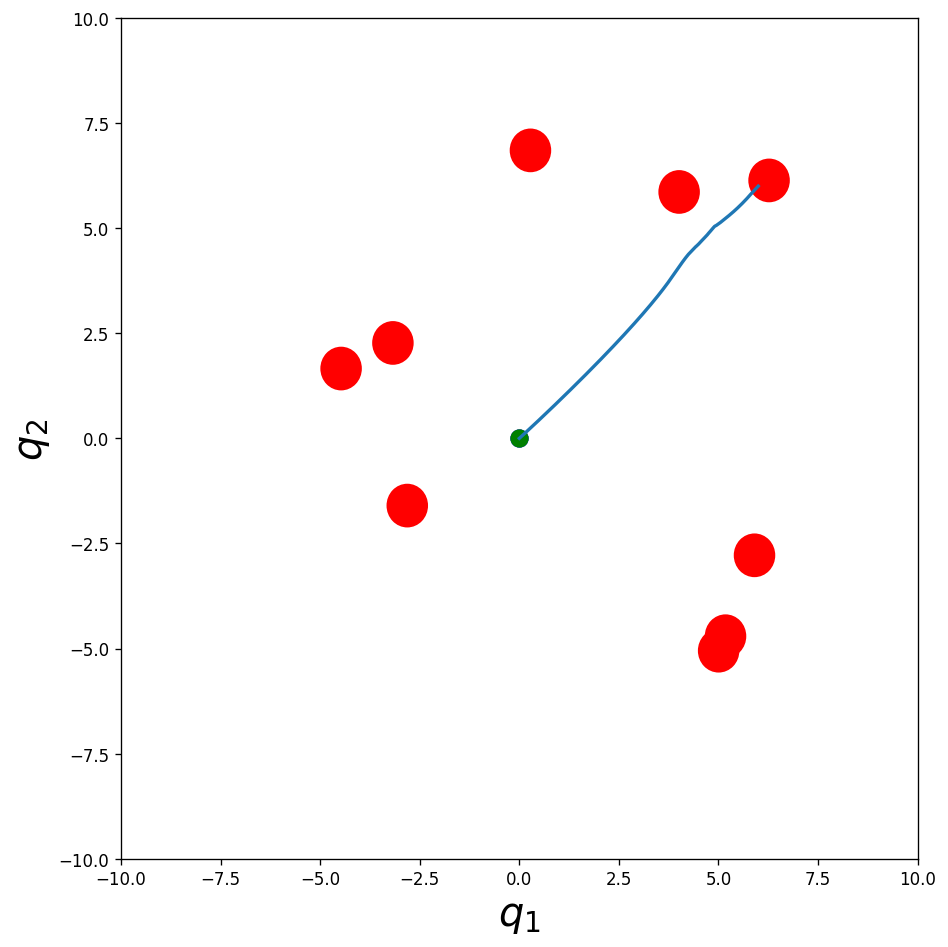

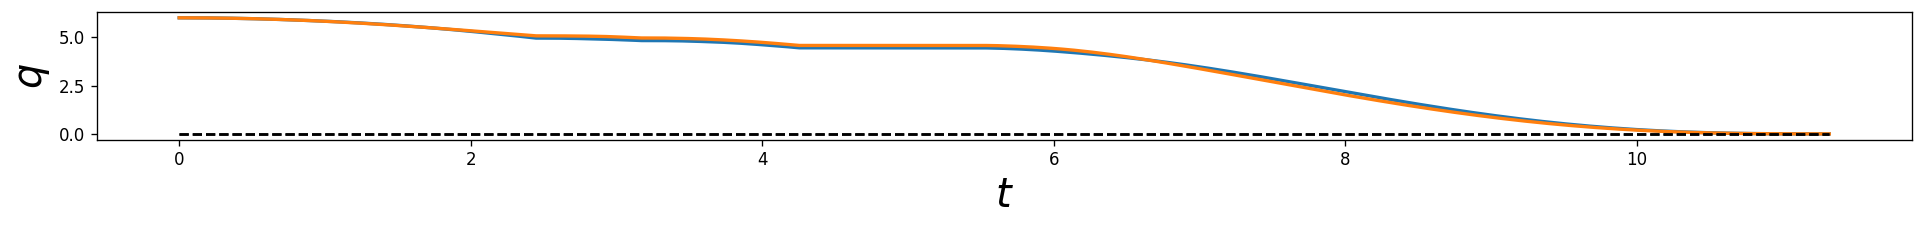

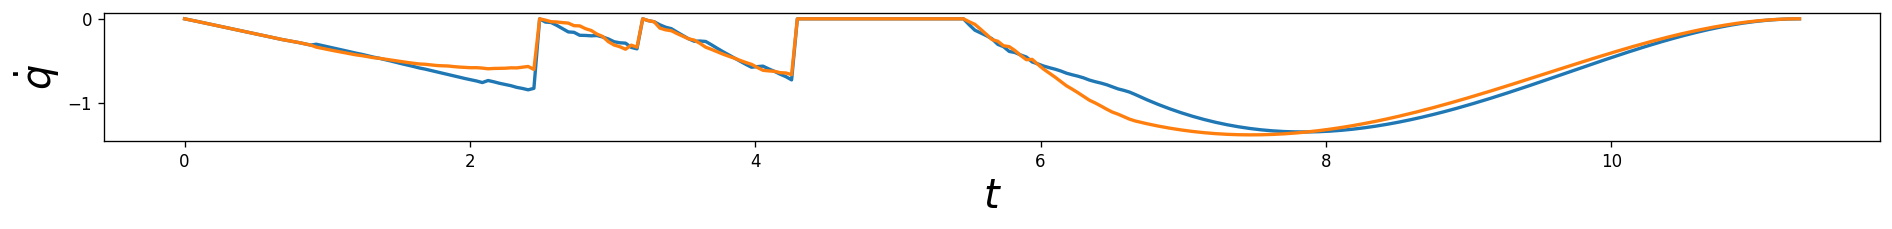

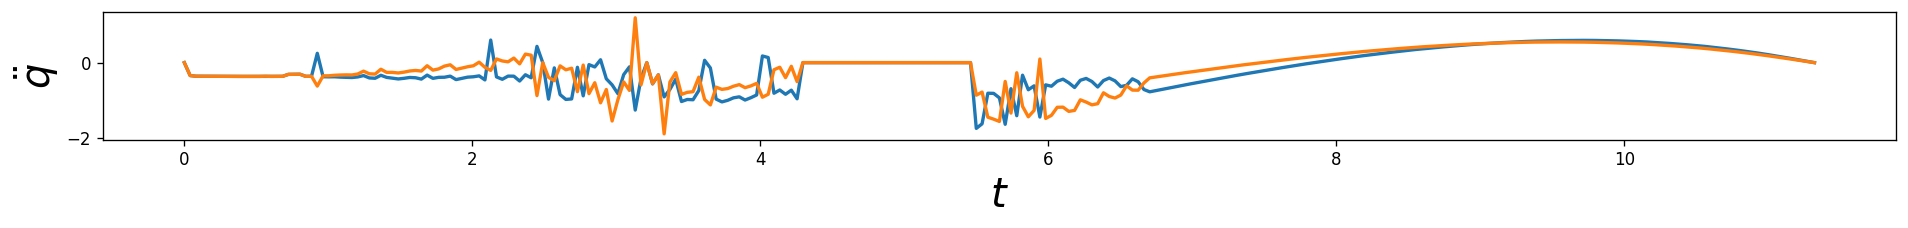

In [9]:
task.plot_environment(q_list)
task.plot_q(q_list)
task.plot_dq(dq_list)
task.plot_ddq(ddq_list)

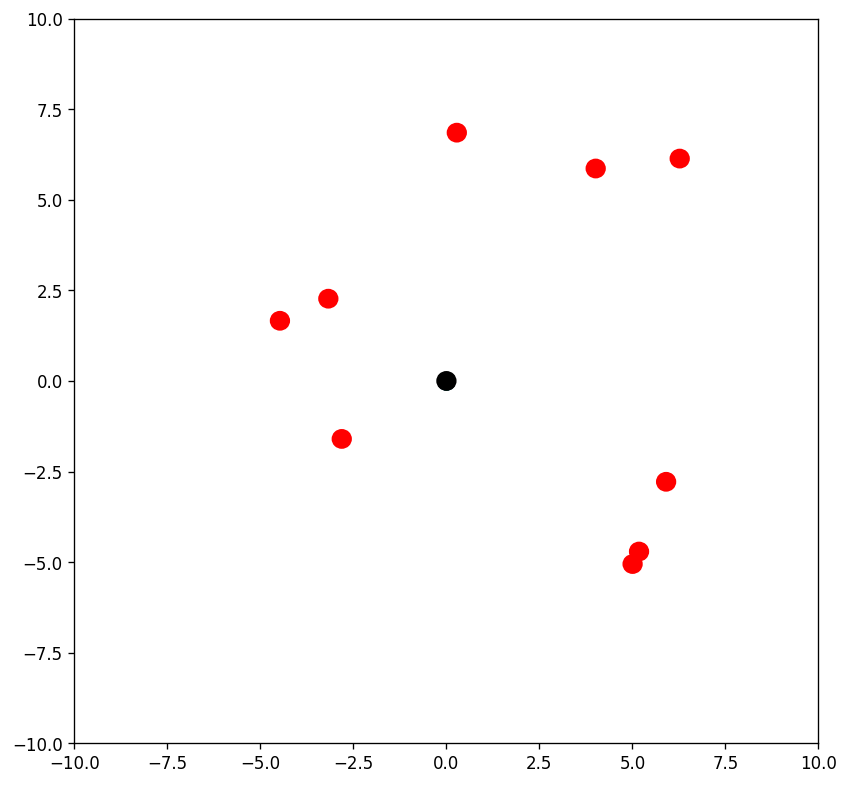

In [10]:
task.set_obstacle_list([])
for i in range(len(dyn_obs_list)):
    x_obs_start = dyn_obs_list[i][0]
    x_obs_end = x_obs_start + T_dur * obs_speed * np.array([np.cos(dir_obs_list[i]*np.pi/8), np.sin(dir_obs_list[i]*np.pi/8)])
    dyn_obs_list[i] = np.array([np.linspace(x_obs_start[0], x_obs_end[0], len(q_list)), np.linspace(x_obs_start[1], x_obs_end[1], len(q_list))]).T
task.set_dyn_obstacle_list(dyn_obs_list)
task.T = T_dur
task.save_animation(q_list)